<a href="https://colab.research.google.com/github/Mahmoud-Attwany/federated-nvd-vulnerability-model/blob/notebooks/Centralized_Model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup lib

In [1]:
# If running in Jupyter (not Colab), use ! to run shell commands
!pip install --upgrade pip
# !pip install --upgrade setuptools
!pip install numpy==1.26.4
!pip install --force-reinstall gensim
!pip install tensorflow==2.18.1
!pip install nltk
#Restart the session

  Using cached gensim-4.3.3-cp311-cp311-win_amd64.whl.metadata (8.2 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
Using cached gensim-4.3.3-cp311-cp311-win_amd64.whl (24.0 MB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
Using cached scipy-1.13.1-cp311-cp311-win_amd64.whl (46.2 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-win_amd64.whl (38 kB)

  Attempting uninstall: wrapt

    Found existing installation: wrapt 1.17.2

    Uninstalling wrapt-1.17.2:

      Successfully uninstalled wrapt-1.17.2

  Attempting uninstall: numpy

    Found existing installation: numpy 1.26.4

   -------- ------------------------------- 1/5 [numpy]
   -------- ------------------------------- 1/5 [numpy]
 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mahmo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# read the dataset

In [ ]:
# Load your data (update path as needed)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/cleaned_balanced_50/Balanced_dataset.csv')

In [ ]:
df.shape

In [ ]:
df.columns

# Basic Data Exploration and Preprocessing

In [4]:
print(f"DataFrame shape: {df.shape}")
print(df.dtypes)
print(df.describe())
print("Missing values per column:")
print(df.isnull().sum())

DataFrame shape: (50922, 15)
id                        object
sourceIdentifier          object
published                 object
lastModified              object
vulnStatus                object
description               object
baseSeverity              object
baseScore                float64
attackVector              object
confidentialityImpact     object
integrityImpact           object
availabilityImpact        object
exploitabilityScore      float64
impactScore              float64
label                      int64
dtype: object
          baseScore  exploitabilityScore   impactScore         label
count  31443.000000         31443.000000  31443.000000  50922.000000
mean       7.123519             2.650116      4.319356      0.500000
std        1.719826             0.951637      1.547574      0.500005
min        0.000000             0.100000      0.000000      0.000000
25%        5.700000             1.800000      3.400000      0.000000
50%        7.500000             2.800000      3.

In [5]:
df['label'].isnull().sum()

0

# Label distribution and correlation (if needed)

In [6]:
print("Label distribution (exploited = 1):")
print(df['label'].value_counts(normalize=True))

Label distribution (exploited = 1):
label
1    0.5
0    0.5
Name: proportion, dtype: float64


# Distribution of data

/tmp/ipython-input-7-2875763017.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Label', y='Percentage', data=label_dist, palette='viridis', width=0.4)


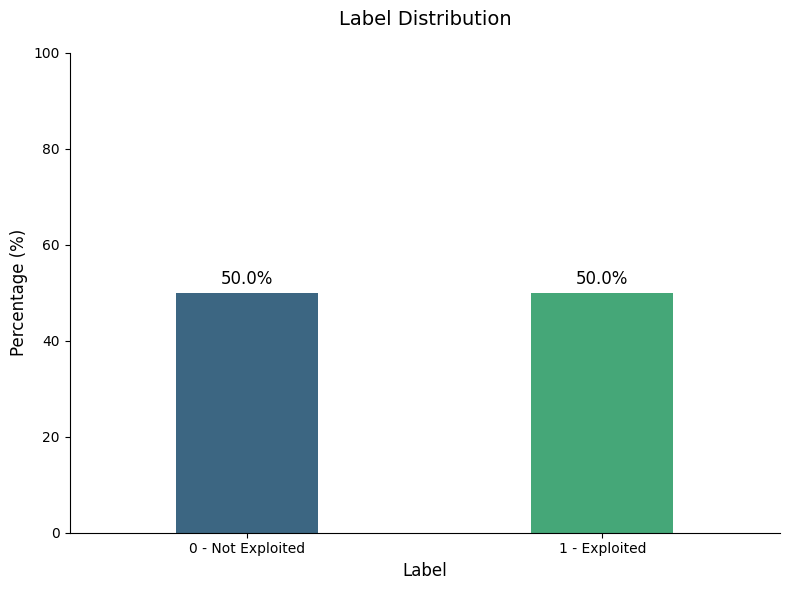

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map labels to readable form
label_map = {0: '0 - Not Exploited', 1: '1 - Exploited'}

# Calculate normalized percentages
label_dist = (df['label']
              .map(label_map)
              .value_counts(normalize=True)
              .sort_index()
              .mul(100)
              .round(2)
              .rename_axis('Label')
              .reset_index(name='Percentage'))

# Create plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Label', y='Percentage', data=label_dist, palette='viridis', width=0.4)

# Titles and labels
plt.title('Label Distribution', fontsize=14, pad=20)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 100)

# Annotate bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

# Data Cleaning: Filter out unwanted descriptions and drop less useful columns

In [8]:
# Clean, lowercase, tokenize, lemmatize
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
df = df[~df['description'].str.lower().str.contains('do not use|rejected|withdrawn', regex=True, na=False)]
df = df.drop(columns=['sourceIdentifier', 'published', 'lastModified'])

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
clean_re = re.compile(r'[^a-zA-Z\s]')

def clean_text(text):
    text = clean_re.sub('', text.lower().strip())
    tokens = word_tokenize(text)
    return [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

df['tokens'] = df['description'].apply(clean_text)
df['description'] = df['tokens'].apply(lambda x: ' '.join(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
# Define categorical and numerical columns
cat_cols = [
    'baseSeverity', 'attackVector'
]
num_cols = []

# Create missing value flags
for col in num_cols:
    df[f"{col}_missing"] = df[col].isna().astype(int)

for col in cat_cols:
    df[f"{col}_missing"] = df[col].isna().astype(int)

# Fill missing categorical values with 'UNKNOWN'
for col in cat_cols:
    df[col] = df[col].fillna('UNKNOWN')

print('done')
# # Impute missing numerical values using KNNImputer
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# df[num_cols] = imputer.fit_transform(df[num_cols])

done


# check if there is null data

In [10]:
df.isnull().sum()

,0
id,0
vulnStatus,0
description,0
baseSeverity,0
baseScore,19353
attackVector,0
confidentialityImpact,19353
integrityImpact,19353
availabilityImpact,19353
exploitabilityScore,19353


In [11]:
import numpy as np
from gensim.models import FastText
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from nltk.tokenize import word_tokenize

# Tokenize description
df['tokens'] = df['description'].apply(word_tokenize)
sentences = df['tokens'].tolist()

# Train FastText model
ft_model = FastText(sentences, vector_size=100, window=5, min_count=2, workers=4, epochs=10)

# Vectorize using FastText
def description_to_vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

fasttext_vectors = np.vstack(df['tokens'].apply(lambda x: description_to_vec(x, ft_model)))

# TF-IDF + SVD
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['description'])

svd = TruncatedSVD(n_components=50, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_encoded = encoder.fit_transform(df[cat_cols])

# Get numeric and missing columns
miss_cols = [col for col in df.columns if col.endswith('_missing')]
# num_data = df[num_cols + miss_cols].values

# Combine all feature sets
X = np.hstack([fasttext_vectors, tfidf_reduced, cat_encoded])
y = df['label'].values

# Final shapes
print("Feature matrix shape:", X.shape)
print("Label vector shape:", y.shape)

Feature matrix shape: (50771, 161)
Label vector shape: (50771,)



Principal Components (transformed data):
[[ 0.17505525 -0.01733431 -0.0706341  ...  0.01477331  0.0221185
   0.01859111]
 [ 0.31184845 -0.3013233   0.34030199 ... -0.00790084 -0.02715502
   0.03827705]
 [ 0.07308911 -0.04942985  0.00873806 ... -0.01418853 -0.04473348
  -0.02479685]
 ...
 [ 0.07374103 -0.1006829  -0.11228765 ... -0.02304501  0.01707446
  -0.11551002]
 [ 0.35169785  0.04294254 -0.17792385 ...  0.12109092 -0.01126077
  -0.00398221]
 [ 0.18843437 -0.11858849 -0.07632907 ...  0.04341171 -0.01512231
   0.02909148]]

Explained Variance Ratio by each component:
[0.02939693 0.03022951 0.02645677 0.0196045  0.01614988 0.01447279
 0.01222105 0.01083166 0.00996551 0.00919417 0.00870463 0.00827569
 0.00806951 0.00780605 0.00771913 0.00731331 0.00707543 0.00681282
 0.00647571 0.00634569 0.00586591 0.00571566 0.00552805 0.00539137
 0.00526715 0.0051909  0.00490274 0.00475855 0.00465058 0.00461092
 0.00454001 0.00437651 0.00422119 0.00408403 0.00404849 0.00394925
 0.00389675 0.003854

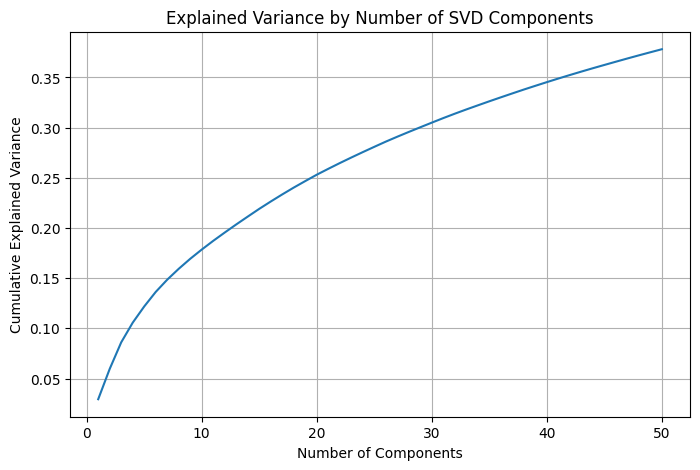

In [12]:
# prompt: write code can PCA through SVD

# The code already uses TruncatedSVD which is a form of SVD for dimensionality reduction.
# You can access the components and variance explained like this:

print("\nPrincipal Components (transformed data):")
print(tfidf_reduced)

print("\nExplained Variance Ratio by each component:")
print(svd.explained_variance_ratio_)

print("\nTotal explained variance by the selected components:")
print(svd.explained_variance_ratio_.sum())

# You can visualize the explained variance to help select the number of components
plt.figure(figsize=(8, 5))
plt.plot(range(1, svd.n_components + 1), np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of SVD Components')
plt.grid(True)
plt.show()

# balance the data set

- split data after balance it

In [13]:
# Split before applying SMOTE (important!)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

- using over sampling technique

# distribution of label after resampling

# Train the model

- cal. the class wights

In [15]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in zip(np.unique(y_train), class_weights)}
class_weights

{0: 0.9979501291699427, 1: 1.0020583093667175}

In [ ]:
import tensorflow as tf # Import tensorflow
from tensorflow.keras import layers, models # Import layers and models
from tensorflow.keras import backend as K # Import Keras backend
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Import EarlyStopping and ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate class weights
# n_samples = len(df)
# n_positive = sum(df['label'])
# pos_weight = (n_samples / (2 * n_positive))
# class_weights = {0: 1.0, 1: pos_weight}


def focal_loss(gamma=2.8, alpha=0.80):  # Increased gamma and alpha for more focus on positive class
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true)
        return K.mean(weight * cross_entropy)
    return focal_loss_fixed

def build_model(input_shape):
    model = models.Sequential([
        layers.Dense(512, activation='softmax', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(256, activation='swish'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='swish'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(64, activation='swish'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(32, activation='swish'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(16, activation='swish'),
        layers.BatchNormalization(),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Reduced learning rate
        loss='Binary Crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train model
# Update class weights to focus more on minority class
#class_weights = {0: 1.0, 1: 4.0}  # Increased weight for positive class

model = build_model((X_train.shape[1],))
history = model.fit(
    X_train, y_train,
    epochs=80,  # Increased epochs
    batch_size=8,  # Reduced batch size
    validation_split=0.0015,  # Reduced validation split
    class_weight=class_weights,
    callbacks=reduce_lr,
    shuffle=True
)

# Evaluate
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.6).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(f"Accuracy: {accuracy_score(y_test, y_pred_binary):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_binary):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_binary):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_binary):.2f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
4436/4436 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.7196 - loss: 0.0404 - precision_2: 0.6657 - recall_2: 0.8675 - val_accuracy: 0.7778 - val_loss: 0.0185 - val_precision_2: 0.7143 - val_recall_2: 0.9259 - learning_rate: 5.0000e-04
Epoch 2/40
4436/4436 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.7656 - loss: 0.0210 - precision_2: 0.6989 - recall_2: 0.9312 - val_accuracy: 0.7778 - val_loss: 0.0165 - val_precision_2: 0.7143 - val_recall_2: 0.9259 - learning_rate: 5.0000e-04
Epoch 3/40
4436/4436 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.7767 - loss: 0.0202 - precision_2: 0.7116 - recall_2: 0.9246 - val_accuracy: 0.7222 - val_loss: 0.0178 - val_precision_2: 0.6579 - val_recall_2: 0.9259 - learning_rate: 5.0000e-04
Epoch 4/40
4436/4436 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7934 - loss: 0.0190 - precision_2: 0.7285 - recall_2: 0.9360 - val_accuracy: 0.8333 - val_loss: 0.0160 - val_precision_2: 0.7647 - val_recall_2: 0.9630 - learning_rate: 5.0000e-04
Epoc

In [20]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_binary):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_binary):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_binary):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_binary):.2f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.2f}")

Accuracy: 0.90
Precision: 0.94
Recall: 0.86
F1 Score: 0.90
ROC-AUC Score: 0.96


# Plot confusion matrix

<Figure size 600x600 with 0 Axes>

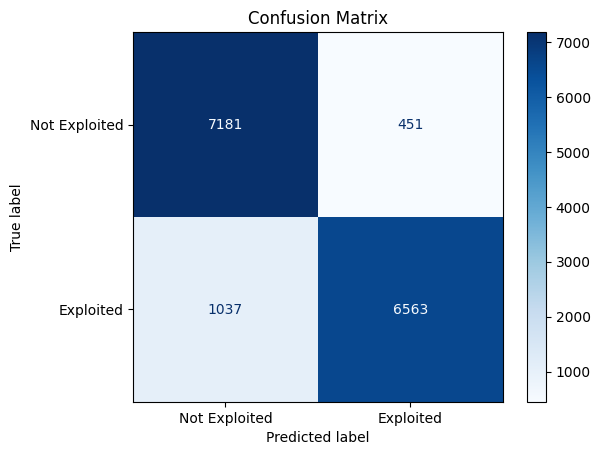

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Import confusion_matrix and ConfusionMatrixDisplay
import matplotlib.pyplot as plt # Import pyplot

cm = confusion_matrix(y_test, y_pred_binary)  # Use y_pred_binary (binary labels) instead of y_pred (probabilities)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Exploited", "Exploited"])
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

* loss and accuracy curve

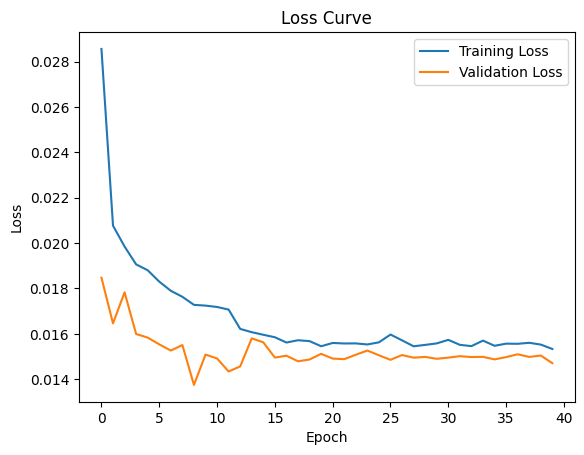

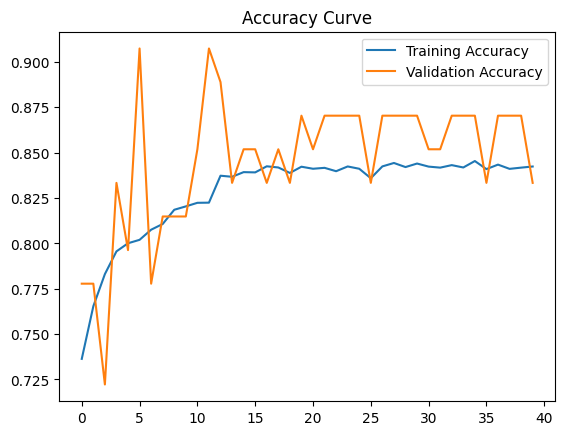

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

In [19]:
model.save('/content/drive/MyDrive/FL/modelalldatafanal.h5')